In [6]:
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [7]:
import numpy as np
import random
import os
import math
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch_geometric.datasets.karate import KarateClub
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_dense_adj
import torch.nn.functional as F

import networkx as nx
from torch_geometric.utils import to_networkx
%matplotlib inline

## Formulation of the GCN and it's intuition

Number of nodes in the graph 6
Number of edges in the graph 9

Adjacency Matrix shape (6, 6)
[[0 1 0 1 0 1]
 [1 0 1 1 1 0]
 [0 1 0 1 0 0]
 [1 1 1 0 0 1]
 [0 1 0 0 0 1]
 [1 0 0 1 1 0]]


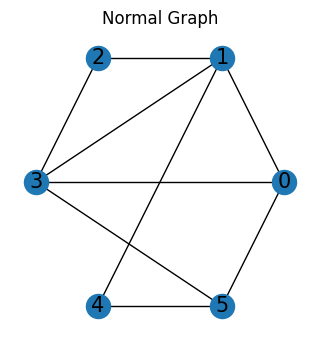

In [8]:
# create a new sample graph
adj = np.array([[0,1,0,1,0,1], [1,0,1,1,1,0], [0,1,0,1,0,0], [1,1,1,0,0,1], [0,1,0,0,0,1], [1,0,0,1,1,0]])
G = nx.from_numpy_array(adj)
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
print(f"Number of nodes in the graph {num_nodes}")
print(f"Number of edges in the graph {num_edges}")
print()

print(f"Adjacency Matrix shape {adj.shape}")
print(adj)

# draw the graph using networkx
pos = nx.circular_layout(G)
plt.figure(figsize=(3, 3))
nx.draw(G, pos, with_labels=True, node_size=300, font_size=15, font_color='black')
plt.title("Normal Graph")
plt.show()

In [9]:
# create random features for each node having 3 dimensions
x = np.round(np.random.randn(num_nodes, 3), 2)
print(f"Feature Matrix shape {x.shape}")
print(x)

Feature Matrix shape (6, 3)
[[ 1.06 -0.19 -0.26]
 [ 1.15 -2.07  0.67]
 [-0.14 -0.77 -0.59]
 [-0.37  0.91  1.15]
 [ 0.58  0.37 -0.61]
 [ 0.06  1.21  0.62]]


We will implement and understand the following equation proposed by Kipf et.al. in the paper titled ["Semi-Supervised Classification with Graph Convolutional Networks"](https://arxiv.org/pdf/1609.02907.pdf). The equation for one layer of Graph Convolution Nwtwork (GCN) is defined as :

$H^{(l+1)} = \sigma(\tilde{D}^{\frac{-1}{2}}\tilde{A}\tilde{D}^{\frac{-1}{2}}H^{(l)}W^{(l)})$

where $\tilde{A} \in \mathbb{R}^{N \times N} = A + I_N$ (Graph with self loops), $N$ is the number of nodes.

$\tilde{D}_{ii} \in \mathbb{R}^{N \times N} = \sum_j\tilde{A}_{ij}$ (Degree matrix)

$W^{(𝑙)} \in \mathbb{R}^{D \times W} $ is $l^{th}$ layer trainable weight matrix.

$\sigma({\cdot})$ denotes an activation function such as ReLU.

$H^{(𝑙)}$ is the matrix of activations in the $l^{th}$ layer; $H^{(0)} = X \in \mathbb{R}^{N \times D}$ (Input feature matrix).



Let's start with the very first part of the equation -
$AH^{(0)}$. Here we are first starting with unnormalized adjacency matrix and later we will build the intuition of normalization.

In [13]:
# First and important part of the equation - AX
print("AX =")
print(adj @ x) # (6 x 6) @ (6 x 3) -> 6 x 3
print()

# Lets understand what this multiplication is doing.
for i in range(num_nodes):
    res = 0.
    print(f"Node {i} is connected to", end=' ')
    for n in G[i].keys():
        res += x[n]
        print(f"Node {n} {x[n]},", end=' ')

    print()
    print(f"Sum of connected neighbors {res}")
    print()
print(f"That's what we call message passing!")


AX =
[[ 0.84  0.05  2.44]
 [ 1.13  0.32 -0.31]
 [ 0.78 -1.16  1.82]
 [ 2.13 -1.82  0.44]
 [ 1.21 -0.86  1.29]
 [ 1.27  1.09  0.28]]

Node 0 is connected to Node 1 [ 1.15 -2.07  0.67], Node 3 [-0.37  0.91  1.15], Node 5 [0.06 1.21 0.62], 
Sum of connected neighbors [0.84 0.05 2.44]

Node 1 is connected to Node 0 [ 1.06 -0.19 -0.26], Node 2 [-0.14 -0.77 -0.59], Node 3 [-0.37  0.91  1.15], Node 4 [ 0.58  0.37 -0.61], 
Sum of connected neighbors [ 1.13  0.32 -0.31]

Node 2 is connected to Node 1 [ 1.15 -2.07  0.67], Node 3 [-0.37  0.91  1.15], 
Sum of connected neighbors [ 0.78 -1.16  1.82]

Node 3 is connected to Node 0 [ 1.06 -0.19 -0.26], Node 1 [ 1.15 -2.07  0.67], Node 2 [-0.14 -0.77 -0.59], Node 5 [0.06 1.21 0.62], 
Sum of connected neighbors [ 2.13 -1.82  0.44]

Node 4 is connected to Node 1 [ 1.15 -2.07  0.67], Node 5 [0.06 1.21 0.62], 
Sum of connected neighbors [ 1.21 -0.86  1.29]

Node 5 is connected to Node 0 [ 1.06 -0.19 -0.26], Node 3 [-0.37  0.91  1.15], Node 4 [ 0.58  0.37 

### But there are **two problems**:
- While updating the node features, the node is **not taking it's own feature** into account.
- Aggregated features are **not normalized**.

Adjacency matrix with self loops
[[1. 1. 0. 1. 0. 1.]
 [1. 1. 1. 1. 1. 0.]
 [0. 1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 0. 1.]
 [0. 1. 0. 0. 1. 1.]
 [1. 0. 0. 1. 1. 1.]]


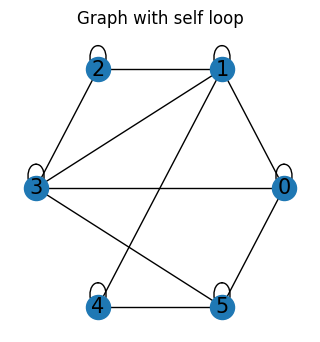

In [11]:
# add self loop for all the nodes
adj_loop = adj + np.eye(adj.shape[0]) # A_tilde = A + I
# There are papers which also suggested doing A + 2I which will give more important to its own features while aggregating
print("Adjacency matrix with self loops")
print(adj_loop)

# Plot the graph with self loops
G_loop = nx.from_numpy_array(adj_loop)
pos = nx.circular_layout(G_loop)
plt.figure(figsize=(3, 3))
nx.draw(G_loop, pos, with_labels=True, node_size=300, font_size=15, font_color='black')
plt.title("Graph with self loop")
plt.show()

Incorporating self-loops into the graph ensures that our own node features are included during the aggregation process.

In [14]:
print("A_tilde X =")
print(adj_loop @ x)
print()

for i in range(num_nodes):
    res = 0.
    print(f"Node {i} is connected to", end=' ')
    for n in G_loop[i].keys():
        res += x[n]
        print(f"Node {n} {x[n]},", end=' ')

    print()
    print(f"Sum of connected neighbors {res}")
    print()

A_tilde X =
[[ 1.9  -0.14  2.18]
 [ 2.28 -1.75  0.36]
 [ 0.64 -1.93  1.23]
 [ 1.76 -0.91  1.59]
 [ 1.79 -0.49  0.68]
 [ 1.33  2.3   0.9 ]]

Node 0 is connected to Node 0 [ 1.06 -0.19 -0.26], Node 1 [ 1.15 -2.07  0.67], Node 3 [-0.37  0.91  1.15], Node 5 [0.06 1.21 0.62], 
Sum of connected neighbors [ 1.9  -0.14  2.18]

Node 1 is connected to Node 0 [ 1.06 -0.19 -0.26], Node 1 [ 1.15 -2.07  0.67], Node 2 [-0.14 -0.77 -0.59], Node 3 [-0.37  0.91  1.15], Node 4 [ 0.58  0.37 -0.61], 
Sum of connected neighbors [ 2.28 -1.75  0.36]

Node 2 is connected to Node 1 [ 1.15 -2.07  0.67], Node 2 [-0.14 -0.77 -0.59], Node 3 [-0.37  0.91  1.15], 
Sum of connected neighbors [ 0.64 -1.93  1.23]

Node 3 is connected to Node 0 [ 1.06 -0.19 -0.26], Node 1 [ 1.15 -2.07  0.67], Node 2 [-0.14 -0.77 -0.59], Node 3 [-0.37  0.91  1.15], Node 5 [0.06 1.21 0.62], 
Sum of connected neighbors [ 1.76 -0.91  1.59]

Node 4 is connected to Node 1 [ 1.15 -2.07  0.67], Node 4 [ 0.58  0.37 -0.61], Node 5 [0.06 1.21 0.62]

Now, lets take the second problem into the account. The aggregated features are not normalized. Here I would love to quote the lines written by [Matthew M. Bernstein](https://mbernste.github.io/) on his blog post explaining [GCN](https://mbernste.github.io/posts/gcn/):

> We see that this aggregation step simply adds together all of the feature vectors of i’s adjacent nodes with its own feature vector. A problem becomes apparent: for nodes that have many neighbors, this sum will be large and we will get vectors with large magnitudes. Conversely, for nodes with few neighbors, this sum will result in vectors with small magnitudes. This is not a desirable property! When attempting to train our neural network, each node’s vector will be highly dependent on the number of neighbors that surround it and it will be challenging to optimize weights that look for signals in the neighboring nodes that are independent of the number of neighbors. Another problem is that if we have multiple layers, the vector associated with a given node may blow up in magnitude the deeper into the layers they go, which can lead to numerical stability issues. Thus, we need a way to perform this aggregation step so that the aggregated vector for each node is of similar magnitude and is not dependent on each node’s number of neighbors.

> One idea to mitigate this issue would be to take the mean of the neighboring vectors rather than the sum.

To calculate the mean of the feature vectors, we can generate the degree matrix $D$, which is essentially the sum of each row in the adjacency matrix. This matrix is *diagonal*, with each entry representing the degree of the corresponding node.

$D_{ii} \in \mathbb{R}^{N \times N} = \sum_j\tilde{A}_{ij}$

Once we calculate the degree matrix $D$, we can do the following:

$D^{-1}\tilde{A}$

where $D^{-1}$ is the element wise inverse of the non-zero elements of the $D$ matrix. This equation makes sure that updated features are normalized.

In [15]:
# compute the degree of each node, which is nothing but the sum of rows of adajcency matrix
D = np.sum(adj_loop, axis=1)
print("Adjacency matrix before")
print(adj_loop)

# Normalization of the adjacency matrix based on the number of neighbors (D_inv A_tilde)
norm = np.diag(D ** -1) @ adj_loop # (N x N) @ (N x N) -> N x N
print("Adjacency matrix after")
print(norm)

Adjacency matrix before
[[1. 1. 0. 1. 0. 1.]
 [1. 1. 1. 1. 1. 0.]
 [0. 1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 0. 1.]
 [0. 1. 0. 0. 1. 1.]
 [1. 0. 0. 1. 1. 1.]]
Adjacency matrix after
[[0.25       0.25       0.         0.25       0.         0.25      ]
 [0.2        0.2        0.2        0.2        0.2        0.        ]
 [0.         0.33333333 0.33333333 0.33333333 0.         0.        ]
 [0.2        0.2        0.2        0.2        0.         0.2       ]
 [0.         0.33333333 0.         0.         0.33333333 0.33333333]
 [0.25       0.         0.         0.25       0.25       0.25      ]]


We observe that after the normalization of adjacency matrix, **all the neighboring nodes with respect to one node has equal importance**.

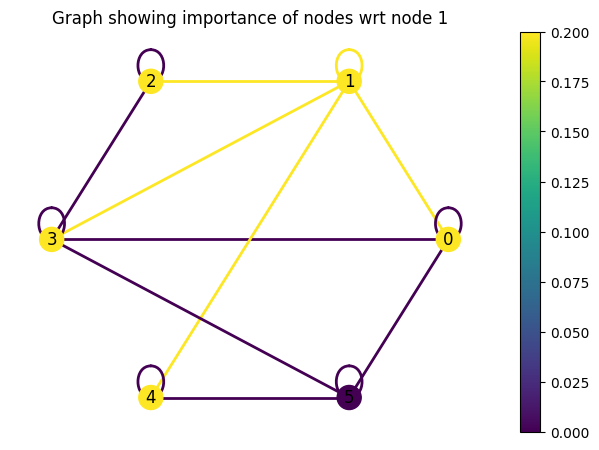

In [16]:
# helper code to draw the graph showing node importance

# pick the node
node = 1

# get the normalized values as color
color_map = norm[node]

# set color to the edges
color_edges = []
for idx, i in enumerate(norm[node]):
    if i > 0.0:
        G_loop.edges[(node, idx)]['weight'] = i * 10
for k in G_loop.edges.keys():
    color_edges.append(G_loop.edges[k]['weight'])

# draw the graph
pos = nx.circular_layout(G_loop)
vmin = min(color_map)
vmax = max(color_map)
plt.figure(figsize=(6, 4))
nx.draw(G_loop, pos, node_color=color_map, width=2,
           with_labels=True, vmin=vmin, vmax=vmax, edge_color=color_edges)
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
plt.colorbar(sm, ax=plt.gca())
plt.title(f"Graph showing importance of nodes wrt node {node}")
plt.show()

### But there is another problem.
It's a simple mean of the neighboring nodes and the resultant adjacency matrix is not symmetric in nature. So, here is the **renormalization trick** proposed by Kipf et. al. The equation is as follows:

$\tilde{D}^{\frac{-1}{2}}\tilde{A}\tilde{D}^{\frac{-1}{2}}$

This *renormalization* trick is different and better than the previous one, let's see how. Again, I would love to quote Matthew here:
> However, ths begs the question, **why use this alternative normalization approach rather than the more straightforward mean normalization?** It turns out that this alternative normalization approach **<u>normalizes for something beyond how many neighbors each node has, it also normalizes for how many neighbors each neighbor has.</u>**

>Let us say we have some node, Node i, with two neighbors: Neighbor 1 and Neighbor 2. Neighbor 1’s only neighbor is i. In contrast, Neighbor 2 is neighbors with many nodes in the graph (including i). Intuitively, because Neighbor 2 has so many neighbors, it has the opportunity to pass its message to more nodes in the graph. In contrast, Neighbor 1 can only pass its message to Node i and thus, its influence on the rest of the graph is dictated by how Node i is passing along its message. We see that Neighbor 1 is sort of “disempowered” relative to Neighbor 2 just based on its location in the graph. Is there some way to compensate for this imbalance? It turns out that the alternative normalization approach (i.e., $\tilde{D}^{\frac{-1}{2}}\tilde{A}\tilde{D}^{\frac{-1}{2}}$), does just that!

> Recall that the i,j element of $\tilde{D}^{\frac{-1}{2}}\tilde{A}\tilde{D}^{\frac{-1}{2}}$ is given by $\frac{1}{\sqrt{d_{ii}d_{jj}}}$. **We see that this value will not only be lower if node i has many neighbors, it will also be lower if node j, its neighbor, has many neighbors!** This helps to boost the signal propogated by nodes with few neighbors relative to nodes with many neighbors.

In [17]:
# renormalization trick from the paper
renorm = np.diag(D ** -0.5) @ adj_loop @ np.diag(D ** -0.5) # (N x N) @ (N x N) @ (N x N) -> N x N
print("Symmetric Normalization using Renormalization trick")
print(renorm)
print()
print("Mean Normalization")
print(norm)

Symmetric Normalization using Renormalization trick
[[0.25       0.2236068  0.         0.2236068  0.         0.25      ]
 [0.2236068  0.2        0.25819889 0.2        0.25819889 0.        ]
 [0.         0.25819889 0.33333333 0.25819889 0.         0.        ]
 [0.2236068  0.2        0.25819889 0.2        0.         0.2236068 ]
 [0.         0.25819889 0.         0.         0.33333333 0.28867513]
 [0.25       0.         0.         0.2236068  0.28867513 0.25      ]]

Mean Normalization
[[0.25       0.25       0.         0.25       0.         0.25      ]
 [0.2        0.2        0.2        0.2        0.2        0.        ]
 [0.         0.33333333 0.33333333 0.33333333 0.         0.        ]
 [0.2        0.2        0.2        0.2        0.         0.2       ]
 [0.         0.33333333 0.         0.         0.33333333 0.33333333]
 [0.25       0.         0.         0.25       0.25       0.25      ]]


Graphs showing importance of node wrt node 1


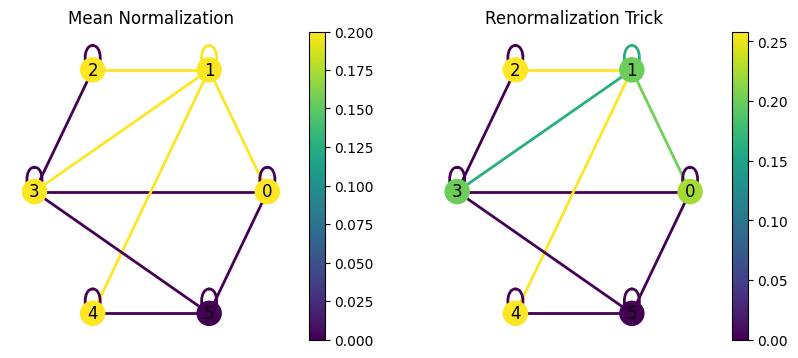

In [18]:
node = 1
print(f"Graphs showing importance of node wrt node {node}")
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
color_map = norm[node]
color_edges = []
for idx, i in enumerate(norm[node]):
    if i > 0.0:
        G_loop.edges[(node, idx)]['weight'] = i * 10
for k in G_loop.edges.keys():
    color_edges.append(G_loop.edges[k]['weight'])
pos = nx.circular_layout(G_loop)
vmin = min(color_map)
vmax = max(color_map)
nx.draw(G_loop, pos, node_color=color_map, width=2,
           with_labels=True, vmin=vmin, vmax=vmax, edge_color=color_edges)
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
plt.colorbar(sm, ax=plt.gca())
plt.title("Mean Normalization")

plt.subplot(1, 2, 2)
color_map = renorm[node]
color_edges = []
for idx, i in enumerate(renorm[node]):
    if i > 0.0:
        G_loop.edges[(node, idx)]['weight'] = i * 10
for k in G_loop.edges.keys():
    color_edges.append(G_loop.edges[k]['weight'])
pos = nx.circular_layout(G_loop)
vmin = min(color_map)
vmax = max(color_map)
nx.draw(G_loop, pos, node_color=color_map, width=2,
           with_labels=True, vmin=vmin, vmax=vmax, edge_color=color_edges)
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
plt.colorbar(sm, ax=plt.gca())
plt.title("Renormalization Trick")
plt.show()

In mean normalization, we observe that the weights associated with Node 1 are identical for all its neighboring nodes. However, using the renormalization trick with respect to Node 1, Node 2 and Node 4 acquire the highest edge weights since they have only three neighbors (including themselves). Subsequently, Node 0 exhibits slightly lower edge weight as it has four neighbors. In contrast, Nodes 1 and 3 has the least edge weights due to having the highest number of neighboring nodes, each with five.

In [ ]:
# A * X
print("Message passing using unnormalized adjacency matrix")
print(adj @ x) # (N x N) @ (N x D) -> (N x D)
print()

# D^(-1/2) * A * D^(-1/2) * X
print("Message passing using renormalized adjacency matrix")
print(renorm @ x) # (N x N) @ (N x D) -> (N x D)

Message passing using unnormalized adjacency matrix
[[-0.81 -0.47 -2.18]
 [ 1.57 -2.5  -0.93]
 [-0.96 -0.11 -3.02]
 [ 2.51 -0.92 -0.69]
 [ 0.81 -0.23 -0.88]
 [ 0.37 -1.2  -0.67]]

Message passing using renormalized adjacency matrix
[[-0.05216253  0.03790325 -0.35279253]
 [ 0.61435841 -0.62663067 -0.52403285]
 [ 0.15212907 -0.46173521 -0.86642731]
 [ 0.26318309 -0.30175686 -0.38267894]
 [ 0.7103792  -0.59369053 -0.14161498]
 [ 0.23038294 -0.44438559  0.08377269]]


## GCN Layer

Let's implement one layer of GCN now.

In [19]:
np.random.seed(2) # setting up the seed
print("Adjacency matrix shape :", adj_loop.shape)
print("Feature matrix shape: ", x.shape)

# create random labels for node classification task
y = np.random.randint(low=0, high=2, size=x.shape[0])
print("Labels", y)
print("Labels shape", y.shape)

Adjacency matrix shape : (6, 6)
Feature matrix shape:  (6, 3)
Labels [0 1 1 0 0 1]
Labels shape (6,)


In [20]:
# convert all the numpy tensor to torch tensor
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)
renorm = torch.tensor(renorm, dtype=torch.float32)

Next, we will implement 2-layer GCN on our sample graph. We will implement the following:

$Z = f(X, A) = \texttt{softmax} \biggl( \tilde{A}\ ReLU\bigl(\tilde{A}XW^{(0)}\bigr)W^{(1)}\biggr)$


In [21]:
# Layer 1
fixed_generator = torch.Generator().manual_seed(4)
output_dim = 2
input_dim = x.shape[1]

# Trainable parameters
w1 = torch.randn(input_dim, output_dim, generator=fixed_generator) # D x W1
b1 = torch.randn(output_dim, generator=fixed_generator) # W1 x 1

# Glorot uniform initialization
stdv = 1. / math.sqrt(w1.shape[1])
w1.uniform_(-stdv, stdv, generator=fixed_generator)
b1.uniform_(-stdv, stdv, generator=fixed_generator)

print(w1)
print(w1.shape)
print()
print(b1)
print(b1.shape)


tensor([[ 0.3726, -0.4049],
        [-0.2735, -0.6526],
        [ 0.0312, -0.2535]])
torch.Size([3, 2])

tensor([0.1519, 0.0329])
torch.Size([2])


In [22]:
# Layer 1 forward pass

# message passing -> D^(-1/2) * A * D^(-1/2) * X
message_agg = renorm @ x # (N x N) @ (N x D) -> (N x D)

# projection to output dimension -> D^(-1/2) * A * D^(-1/2) * X * W_1
z = message_agg @ w1 + b1 # (N x D) @ (D x W1) + (W1 x 1) -> (N x W1)

# apply non-linearity
z = F.relu(z)

print("Output of first layer")
print(z)
print(z.shape)

Output of first layer
tensor([[0.3379, 0.0000],
        [0.4438, 0.0753],
        [0.3701, 0.2639],
        [0.3544, 0.0000],
        [0.3625, 0.0000],
        [0.1385, 0.0000]])
torch.Size([6, 2])


In [23]:
fixed_generator = torch.Generator().manual_seed(5)

# Layer 2
output_dim = 2
input_dim = z.shape[1]

# Trainable parameters
w2 = torch.randn(input_dim, output_dim, generator=fixed_generator) # W1 x W2
b2 = torch.randn(output_dim, generator=fixed_generator) # W2 x 1

# Glorot uniform initialization
stdv = 1. / math.sqrt(w2.shape[1])
w2.uniform_(-stdv, stdv, generator=fixed_generator)
b2.uniform_(-stdv, stdv, generator=fixed_generator)

print(w2)
print(w2.shape)
print()
print(b2)
print(b2.shape)

tensor([[-0.6047,  0.2253],
        [ 0.3041,  0.1122]])
torch.Size([2, 2])

tensor([0.6801, 0.2124])
torch.Size([2])


In [24]:
# layer 2 forward pass

# D^(-1/2) * A * D^(-1/2) * z
message_agg = renorm @ z # (N x N) @ (N x W1) -> (N x W1)

# D^(-1/2) * A * D^(-1/2) * z * W_2
out = message_agg @ w2 + b2 # (N x W1) @ (W1 x W2) + (W2 x 1) -> (N x W2)

print("Output of second layer")
print(out)
print(out.shape)

Output of second layer
tensor([[0.5053, 0.2813],
        [0.4488, 0.3173],
        [0.5136, 0.2986],
        [0.4867, 0.3032],
        [0.5195, 0.2766],
        [0.4969, 0.2806]])
torch.Size([6, 2])


In [25]:
# compute the loss
loss = F.cross_entropy(out, y) # same as F.nll_loss(F.log_softmax(out, dim=1), y)
print(f"Loss of the network =", loss.item())

Loss of the network = 0.6911020874977112


## GCN Definition

Let's implement a 2-layer GCN properly using classes.

In [26]:
# One layer
class GCNLayer(nn.Module):
    def __init__(self, in_feat, out_feat):
        super().__init__()
        self.in_feat = in_feat
        self.out_feat = out_feat

        # trainable parameters
        self.projection = nn.Linear(in_feat, out_feat)

    def forward(self, x, A_norm):
        x = torch.mm(A_norm, x) # message passing, (N x N) @ (N x D) -> (N x D)
        x = self.projection(x) # projection, (N x D) @ (D x W) -> (N x W)
        return x

    def __repr__(self):
        return f"GCNLayer ({self.in_feat} -> {self.out_feat})"

class GCNModel(nn.Module):
    def __init__(self, in_feat, num_hidden, nclass, actn, dropout=None):
        super().__init__()

        # layer initialization
        self.gcn_l1 = GCNLayer(in_feat, num_hidden)
        self.gcn_l2 = GCNLayer(num_hidden, nclass)

        # sometimes people also add a linear layer after the gcn layers. That's optional though. Kipf hasn't done that.
        self.dropout = dropout
        self.actn = actn

    def forward(self, x, A_norm):
        x = self.actn(self.gcn_l1(x, A_norm)) # (N x W1)
        if self.dropout is not None:
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.gcn_l2(x, A_norm) # (N x W2)
        return x

## Dataset

We will use the [Cora dataset](https://paperswithcode.com/dataset/cora) for our demonstration purpose. This is one of the dataset used by the author as well. I have taken the dataset implementation from [Geometric Deep Learning Course](https://geometricdeeplearning.com/lectures/) by [Michael M. Bronstein](https://www.imperial.ac.uk/people/m.bronstein), [Joan Bruna](https://cims.nyu.edu/~bruna/), [Taco Cohen](https://tacocohen.wordpress.com/), and [Petar Veličković](https://petar-v.com/). I highly recommend taking this course if you are interested in Geometric Deep Learning.

In [27]:
class CoraDataset(object):
    def __init__(self, split="public"):
        super(CoraDataset, self).__init__()
        self.cora_pyg = Planetoid(root='/tmp/Cora', name='Cora', split=split)
        self.cora_data = self.cora_pyg[0]
        self.train_mask = self.cora_data.train_mask
        self.valid_mask = self.cora_data.val_mask
        self.test_mask = self.cora_data.test_mask

    def train_val_test_split(self):
        train_x = self.cora_data.x[self.cora_data.train_mask]
        train_y = self.cora_data.y[self.cora_data.train_mask]

        valid_x = self.cora_data.x[self.cora_data.val_mask]
        valid_y = self.cora_data.y[self.cora_data.val_mask]

        test_x = self.cora_data.x[self.cora_data.test_mask]
        test_y = self.cora_data.y[self.cora_data.test_mask]
        return train_x, train_y, valid_x, valid_y, test_x, test_y

    def get_fullx(self):
        return self.cora_data.x

    def get_adjacency_matrix(self):
        # We will ignore this for the first part
        adj = to_dense_adj(self.cora_data.edge_index)[0]
        return adj

In [28]:
# Lets download the cora dataset and get the splits
cora_data = CoraDataset()
train_x, train_y, valid_x, valid_y, test_x, test_y = cora_data.train_val_test_split()
A = cora_data.get_adjacency_matrix()
X = cora_data.get_fullx()

Processing...
Done!


Let's get the dataset infromation.

In [29]:
print('======================')
print(f'Number of graphs: {len(cora_data.cora_pyg)}')
print(f'Number of features: {cora_data.cora_data.num_features}')
print(f'Number of classes: {cora_data.cora_pyg.num_classes}')
print()
print(f'Number of nodes/samples: {cora_data.cora_data.num_nodes}')
print(f'Number of edges: {cora_data.cora_data.num_edges}')
print(f'Average node degree: {cora_data.cora_data.num_edges / cora_data.cora_data.num_nodes:.2f}')
print(f'Number of training nodes: {cora_data.cora_data.train_mask.sum()}')
print(f'Training node label rate: {int(cora_data.cora_data.train_mask.sum()) / cora_data.cora_data.num_nodes:.2f}')
print(f'Contains isolated nodes: {cora_data.cora_data.has_isolated_nodes()}')
print(f'Contains self-loops: {cora_data.cora_data.has_self_loops()}')
print(f'Is undirected: {cora_data.cora_data.is_undirected()}')
print()
print(f"Adjacency Matrix A: {A.shape}")
print(f"Feature Matrix X: {X.shape}")
print()
print(f"Train shape x: {train_x.shape}, y: {train_y.shape}")
print(f"Val shape x: {valid_x.shape}, y: {valid_y.shape}")
print(f"Test shape x: {test_x.shape}, y: {test_y.shape}")
print('======================')

Number of graphs: 1
Number of features: 1433
Number of classes: 7

Number of nodes/samples: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True

Adjacency Matrix A: torch.Size([2708, 2708])
Feature Matrix X: torch.Size([2708, 1433])

Train shape x: torch.Size([140, 1433]), y: torch.Size([140])
Val shape x: torch.Size([500, 1433]), y: torch.Size([500])
Test shape x: torch.Size([1000, 1433]), y: torch.Size([1000])


We observe that the Cora dataset comprises a total of 2708 samples or nodes. There are a total of 10556 edges, and each node is characterized by a 1433-dimensional feature vector. Each sample is classified into one of 7 classes. Another point worth noting is that out of the 2708 nodes, only 140 are utilized for training purposes. We will use 500 samples for validation and 1000 samples for testing.

Before delving into the training of GCN, let's initially train a basic 2-layer Multi-Layer Perceptron (MLP) to assess performance without incorporating the graph structure.

## MLP Definition

Let's implement a simple MLP. The code for MLP implementation and training is taken from the [GDL course](https://geometricdeeplearning.com/lectures/).

In [30]:
class MLP(nn.Module):
    def __init__(self, in_feat, num_hidden, nclass):
        super().__init__()
        self.linear1 = nn.Linear(in_feat, num_hidden)
        self.linear2 = nn.Linear(num_hidden, nclass)
        self.bn1 = nn.BatchNorm1d(num_hidden)

    def forward(self, x):
        x = self.bn1(F.relu(self.linear1(x)))
        x = F.dropout(x, training=self.training)
        x = self.linear2(x)
        return x

In [31]:
def train_mlp_cora(x, y, model, optimiser):
    model.train()
    optimiser.zero_grad()
    out = model(x)
    loss = F.cross_entropy(out, y)
    loss.backward()
    optimiser.step()
    return loss.data

def evaluate_mlp_cora(x, y, model):
    model.eval()
    out = model(x)
    out = out.data.max(1)[1]
    num_correct = out.eq(y.data).sum()
    num_total = len(y)
    accuracy = 100.0 * (num_correct/num_total)
    return accuracy

def train_eval_loop(model, train_x, train_y, valid_x, valid_y, test_x, test_y):
    training_stats = []
    optimiser = optim.Adam(model.parameters(), lr=LR)

    for epoch in range(NUM_EPOCHS):
        train_loss = train_mlp_cora(train_x, train_y, model, optimiser)
        train_acc = evaluate_mlp_cora(train_x, train_y, model)
        valid_acc = evaluate_mlp_cora(valid_x, valid_y, model)
        if epoch % 10 == 0:
            print(f"Epoch {epoch} with train loss: {train_loss:.3f} train accuracy: {train_acc:.3f}",
                    f"validation accuracy: {valid_acc:.3f}")
        training_stats.append([train_acc.detach().cpu(), valid_acc.detach().cpu(), epoch])

    test_acc = evaluate_mlp_cora(test_x, test_y, model)
    print(f"Our final test accuracy for the MLP is: {test_acc:.3f}")
    return training_stats

def plot_stats(training_stats, model_name):
    ts = np.array(training_stats)
    epochs = ts[:, 2]
    train_acc = ts[:, 0]
    val_acc = ts[:, 1]

    plt.plot(epochs, train_acc, 'go-', label='Training Accuracy', linewidth=2)
    plt.plot(epochs, val_acc, 'bo--', label='Validation Accuracy')
    plt.xlabel(f'Epochs')
    plt.ylabel(f'Accuracy')
    plt.title(f"Performance of {model_name}")
    plt.legend()
    plt.show()

In [33]:
# Initialize the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [34]:
NUM_EPOCHS = 101
LR = 0.01

Epoch 0 with train loss: 2.192 train accuracy: 27.143 validation accuracy: 17.600
Epoch 10 with train loss: 0.863 train accuracy: 99.286 validation accuracy: 48.200
Epoch 20 with train loss: 0.394 train accuracy: 100.000 validation accuracy: 52.000
Epoch 30 with train loss: 0.298 train accuracy: 100.000 validation accuracy: 53.000
Epoch 40 with train loss: 0.157 train accuracy: 100.000 validation accuracy: 52.800
Epoch 50 with train loss: 0.102 train accuracy: 100.000 validation accuracy: 52.600
Epoch 60 with train loss: 0.108 train accuracy: 100.000 validation accuracy: 53.200
Epoch 70 with train loss: 0.101 train accuracy: 100.000 validation accuracy: 53.000
Epoch 80 with train loss: 0.079 train accuracy: 100.000 validation accuracy: 52.800
Epoch 90 with train loss: 0.051 train accuracy: 100.000 validation accuracy: 52.200
Epoch 100 with train loss: 0.070 train accuracy: 100.000 validation accuracy: 51.400
Our final test accuracy for the MLP is: 53.300


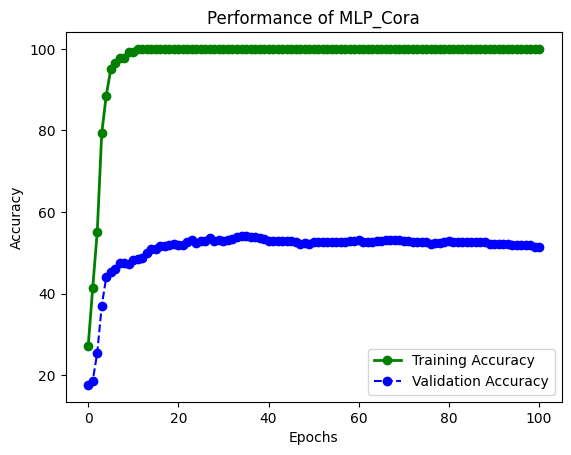

In [ ]:
# training simple 2-layer MLP
model = MLP(train_x.shape[-1], 16, 7).to(device)
train_x = train_x.to(device)
train_y = train_y.to(device)
valid_x = valid_x.to(device)
valid_y = valid_y.to(device)
test_x = test_x.to(device)
test_y = test_y.to(device)
# Run training loop
train_stats_mlp_cora = train_eval_loop(model, train_x, train_y, valid_x, valid_y, test_x, test_y)
plot_stats(train_stats_mlp_cora, "MLP_Cora")

## Semi-supervised learning: Transductive vs Inductive

We will use the **entire adjacency and node feature matrix each time we call the GCNLayer** as opposed to the specific subsets of the train/validation/test we did earlier with the MLP. This is **because nodes from the different splits share edges with those from the other splits and building our representation requires these.** **Hence, the learning performed with our GCNLayer is an instance of transductive semi-supervised learning as the model gets to see all of the observations in the dataset.** This is different to the inductive learning performed on the MLP where the model only sees the train observations during training and only sees validation/test observations for prediction. It is important to note that despite the model using all of the observations and entire adjacency matrix it does not use all of the targets!

In [35]:
def train_gnn_cora(A_norm, X, y, mask, model, optimiser):
    model.train()
    optimiser.zero_grad()
    out = model(X, A_norm)[mask] # only using the train samples to calculate the loss
    loss = F.cross_entropy(out, y) # this kind of learning is called transductive learning.
    loss.backward()
    optimiser.step()
    return loss.item()

def evaluate_gnn_cora(A_norm, X, y, mask, model):
    model.eval()
    out = model(X, A_norm)[mask]
    out = out.data.max(1)[1]
    num_correct = out.eq(y.data).sum()
    num_total = len(y)
    accuracy = 100.0 * (num_correct/num_total)
    return accuracy

def train_eval_loop_gnn_cora(model, A_norm, train_x, train_y, train_mask,
                        valid_x, valid_y, valid_mask,
                        test_x, test_y, test_mask
                    ):
    optimiser = optim.Adam(model.parameters(), lr=LR, weight_decay=5e-4)
    training_stats = []
    # Training loop
    for epoch in range(NUM_EPOCHS):
        train_loss = train_gnn_cora(A_norm, train_x, train_y, train_mask, model, optimiser)
        train_acc = evaluate_gnn_cora(A_norm, train_x, train_y, train_mask, model)
        valid_acc = evaluate_gnn_cora(A_norm, valid_x, valid_y, valid_mask, model)
        if epoch % 10 == 0:
            print(f"Epoch {epoch} with train loss: {train_loss:.3f} train accuracy: {train_acc:.3f} validation accuracy: {valid_acc:.3f}")

        training_stats.append([train_acc.detach().cpu(), valid_acc.detach().cpu(), epoch])

    test_acc = evaluate_gnn_cora(A_norm, test_x, test_y, test_mask, model)
    print(f"Our final test accuracy for the GCN is: {test_acc:.3f}")
    return training_stats

In [ ]:
# get the adjacency matrix
A = cora_data.get_adjacency_matrix().to(device) # (2708 x 2708)

# get the feature matrix
X = cora_data.get_fullx().to(device) # (2708 x 1433)

# add self loop
A = A + torch.eye(A.shape[0]).to(device) # (2708 x 2708)

# apply renormalization trick
D = torch.sum(A, dim=1) # (2708 x 1)
A_norm = torch.diag(D ** (-1/2)) @ A @ torch.diag(D ** (-1/2)) # (2708 x 2708)

Epoch 0 with train loss: 1.959 train accuracy: 30.714 validation accuracy: 14.600
Epoch 10 with train loss: 1.056 train accuracy: 95.000 validation accuracy: 71.000
Epoch 20 with train loss: 0.391 train accuracy: 99.286 validation accuracy: 77.000
Epoch 30 with train loss: 0.134 train accuracy: 100.000 validation accuracy: 79.400
Epoch 40 with train loss: 0.086 train accuracy: 100.000 validation accuracy: 78.600
Epoch 50 with train loss: 0.065 train accuracy: 100.000 validation accuracy: 78.400
Epoch 60 with train loss: 0.056 train accuracy: 100.000 validation accuracy: 77.600
Epoch 70 with train loss: 0.063 train accuracy: 100.000 validation accuracy: 78.000
Epoch 80 with train loss: 0.048 train accuracy: 100.000 validation accuracy: 77.200
Epoch 90 with train loss: 0.050 train accuracy: 100.000 validation accuracy: 77.400
Epoch 100 with train loss: 0.056 train accuracy: 100.000 validation accuracy: 77.000
Our final test accuracy for the GCN is: 80.900


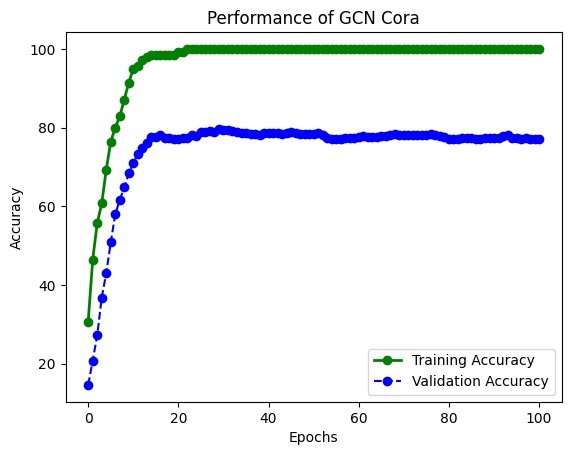

In [ ]:
# create a 2-layer GCN model where hidden layer feature has 16-dimensions.
# These numbers are taken from the paper.
model = GCNModel(in_feat=train_x.shape[-1], num_hidden=16, nclass=7, actn=F.relu, dropout=0.5).to(device)

train_y = train_y.to(device)
valid_y = valid_y.to(device)
test_y = test_y.to(device)

train_mask = cora_data.train_mask.to(device)
valid_mask = cora_data.valid_mask.to(device)
test_mask = cora_data.test_mask.to(device)

# we are passing full features instead of just training features.
train_stats_gnn_cora = train_eval_loop_gnn_cora(model, A_norm, X, train_y, train_mask,
                                          X, valid_y, valid_mask,
                                          X, test_y, test_mask
                                       )
plot_stats(train_stats_gnn_cora, model_name="GCN Cora")

## Node Embeddings With Random Weights
Untrained GCN model with random weights can serve as a powerful feature extractor for nodes in a graph. We will implement the following GCN model:

$Z = \texttt{tanh} \biggl(\tilde{A}\ \texttt{tanh} \bigl( \tilde{A}\ \texttt{tanh} \bigl(\tilde{A}XW^{(0)} \bigr)W^{(1)}\bigr)W^{(2)}\biggr)$

We are going to use the [Zachary Karate Club Dataset](http://konect.cc/networks/ucidata-zachary/) which has 34 nodes connected by 156 (undirected and unweighted) edges. Every node is labeled by one of four classes. Now, we will start with the feature matrix $X = I_N$ ($N \times N$ identity matrix) where $N$ being number of nodes. Let's create the graph and get all the information.

Number of graphs: 1
Number of features: 34
Number of classes: 4

Number of nodes/samples: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True

Adjacency Matrix A: torch.Size([34, 34])
Feature Matrix X: torch.Size([34, 34])

Train shape x: torch.Size([4, 34]), y: torch.Size([4])


/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  node_collection = ax.scatter(


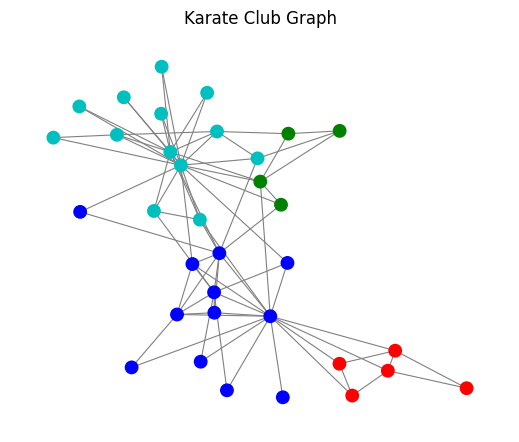

In [ ]:
dataset = KarateClub()
data = dataset[0]
adj_karate = to_dense_adj(data.edge_index)[0]
x_karate = data.x # Identity matrix of 34 x 34

train_x_karate = data.x[data.train_mask]
train_y_karate = data.y[data.train_mask]

print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {data.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print()
print(f'Number of nodes/samples: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
print(f'Contains self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')
print()
print(f"Adjacency Matrix A: {adj_karate.shape}")
print(f"Feature Matrix X: {x_karate.shape}")
print()
print(f"Train shape x: {train_x_karate.shape}, y: {train_y_karate.shape}")
print('======================')

# plot the network
G_karate = nx.karate_club_graph()
cmap = {0:'c', 1:'b', 2:'g', 3:'r'}
color = [cmap[c] for c in data.y.numpy().tolist()]
plt.figure(figsize=(5, 4))
nx.draw_spring(G_karate, with_labels=False, node_size=80, font_size=10, font_color='black', node_color=color,
              cmap='hsv', edge_color='grey', vmin=-2, vmax=3, width=0.8)
plt.title("Karate Club Graph")
plt.show()

Let's construct the 3-layer GCN model as discussed for this task. Following the paper's recommendations, we will employ 4-dimensional hidden layers and a 2-dimensional output layer for direct plotting and visualization of the outputs. At this stage, we won't be training the GCN model; instead, we'll perform a single forward pass of the input data to obtain the node features. Additionally, I'm making a slight modification to the GCN implementation: given the highly random weights initialization and the absence of training, I am introducing batch normalization between the GCN layers to ensure the activations follow a specific distribution.

In [ ]:
# define the 3-layer GCN model
class GCNModel_karate(nn.Module):
    def __init__(self, in_feat, num_hidden, nclass, actn, dropout=True):
        super().__init__()
        self.gcn_l1 = GCNLayer(in_feat, num_hidden)
        self.gcn_l2 = GCNLayer(num_hidden, num_hidden)
        self.gcn_l3 = GCNLayer(num_hidden, nclass)
        self.bn1 = nn.BatchNorm1d(num_hidden)
        self.bn2 = nn.BatchNorm1d(num_hidden)

        self.dropout = dropout
        self.actn = actn

    def forward(self, x, A_norm):
        x = self.bn1(self.actn(self.gcn_l1(x, A_norm)))
        x = self.bn2(self.actn(self.gcn_l2(x, A_norm)))
        x = self.actn(self.gcn_l3(x, A_norm))
        return x

# add self loop to the adjacency matrix
adj_karate_loop = adj_karate + torch.eye(adj_karate.shape[0])

# get the degree matrix
D_karate = torch.sum(adj_karate_loop, dim=1)

# renormalize the adjacency matrix
adj_karate_norm = torch.diag(D_karate ** -0.5) @ adj_karate_loop @ torch.diag(D_karate ** -0.5)

GCNModel_karate(
  (gcn_l1): GCNLayer (34 -> 4)
  (gcn_l2): GCNLayer (4 -> 4)
  (gcn_l3): GCNLayer (4 -> 2)
  (bn1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


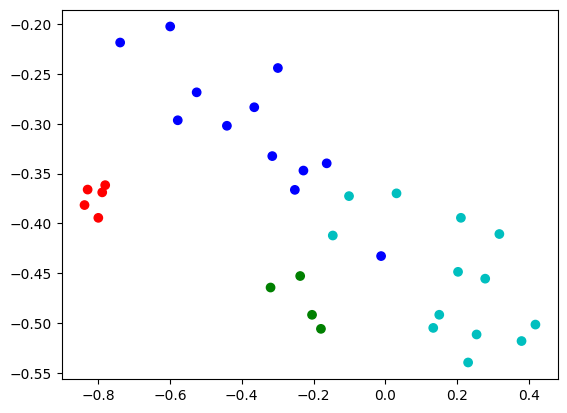

In [ ]:
# create the GCN model with 4-dimensional hidden layers and 2-dimensional output layer
model_karate = GCNModel_karate(in_feat=34, num_hidden=4, nclass=2, actn=F.tanh, dropout=False)

# print the model
print(model_karate)
model_karate.train()

# lets do just a forward pass and get the outputs from the model
out = model_karate(x_karate, adj_karate_norm)
out_numpy = out.detach().numpy()

# plot the 2-dimensional outputs with the node labels depicted in colors
plt.scatter(out_numpy[:, 0], out_numpy[:, 1], c=color)
plt.show()

This illustrates the effectiveness of GCN. It's evident that a single pass through the GCN model, even with an untrained model and features set to an identity matrix, can generate embeddings that readily form distinguishable clusters corresponding to their classes. The model captures meaningful representations through the relationships between the samples.

## GCN Variants
Next we will implement all the GCN variants mentioned in the paper. These variants are defined as follows:
- Single Parameter Model - $(I_N + D^{\frac{-1}{2}}AD^{\frac{-1}{2}})XΘ$
- 1st Order term only - $(D^{\frac{-1}{2}}AD^{\frac{-1}{2}})XΘ$
- 1st order model - $XΘ_0 + (D^{\frac{-1}{2}}AD^{\frac{-1}{2}})XΘ_1$
- Chebyshev Polynomials - $\sum_{k=0}^KT_k(\tilde{L})X\theta_k$ for k = 2

## Single Parameter model
This model is defined as follows:

$(I_N + D^{\frac{-1}{2}}AD^{\frac{-1}{2}})XΘ$



In [ ]:
A = cora_data.get_adjacency_matrix().to(device)
X = cora_data.get_fullx().to(device)

# implement the adjacency part of the variant here.
D = torch.sum(A, dim=1)
I = torch.eye(A.shape[0]).to(device)
A_norm = I + (torch.diag(D ** (-1/2)) @ A @ torch.diag(D ** (-1/2)))

Epoch 0 with train loss: 1.964 train accuracy: 60.714 validation accuracy: 38.400
Epoch 10 with train loss: 0.354 train accuracy: 100.000 validation accuracy: 75.000
Epoch 20 with train loss: 0.054 train accuracy: 100.000 validation accuracy: 78.200
Epoch 30 with train loss: 0.041 train accuracy: 100.000 validation accuracy: 76.800
Epoch 40 with train loss: 0.040 train accuracy: 100.000 validation accuracy: 77.000
Epoch 50 with train loss: 0.020 train accuracy: 100.000 validation accuracy: 76.200
Epoch 60 with train loss: 0.036 train accuracy: 100.000 validation accuracy: 76.400
Epoch 70 with train loss: 0.017 train accuracy: 100.000 validation accuracy: 77.200
Epoch 80 with train loss: 0.031 train accuracy: 100.000 validation accuracy: 77.200
Epoch 90 with train loss: 0.025 train accuracy: 100.000 validation accuracy: 77.000
Epoch 100 with train loss: 0.017 train accuracy: 100.000 validation accuracy: 77.000
Our final test accuracy for the GCN is: 79.800


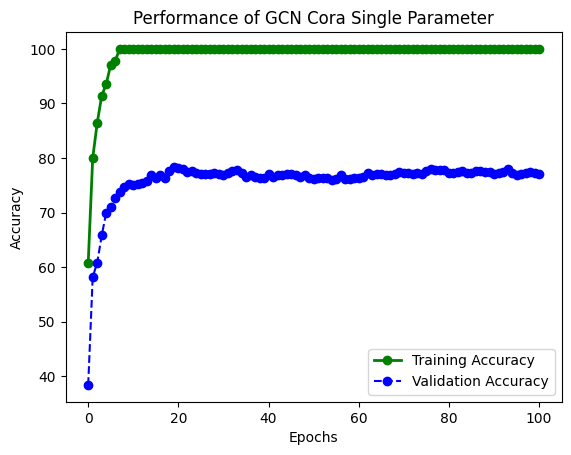

In [ ]:
model = GCNModel(in_feat=train_x.shape[-1], num_hidden=16, nclass=7, actn=F.relu, dropout=0.5).to(device)

train_y = train_y.to(device)
valid_y = valid_y.to(device)
test_y = test_y.to(device)

train_mask = cora_data.train_mask.to(device)
valid_mask = cora_data.valid_mask.to(device)
test_mask = cora_data.test_mask.to(device)

train_stats_gnn_cora = train_eval_loop_gnn_cora(model, A_norm, X, train_y, train_mask,
                                          X, valid_y, valid_mask,
                                          X, test_y, test_mask
                                       )
plot_stats(train_stats_gnn_cora, model_name="GCN Cora Single Parameter")

## 1st order term only
This model is defined as follows:

$(D^{\frac{-1}{2}}AD^{\frac{-1}{2}})XΘ$

In [ ]:
A = cora_data.get_adjacency_matrix().to(device)
X = cora_data.get_fullx().to(device)

# implement the adjacency part of the variant here.
D = torch.sum(A, dim=1)
A_norm = torch.diag(D ** (-1/2)) @ A @ torch.diag(D ** (-1/2))

Epoch 0 with train loss: 1.952 train accuracy: 29.286 validation accuracy: 35.600
Epoch 10 with train loss: 1.145 train accuracy: 96.429 validation accuracy: 69.600
Epoch 20 with train loss: 0.487 train accuracy: 98.571 validation accuracy: 78.400
Epoch 30 with train loss: 0.241 train accuracy: 100.000 validation accuracy: 76.000
Epoch 40 with train loss: 0.146 train accuracy: 100.000 validation accuracy: 75.800
Epoch 50 with train loss: 0.155 train accuracy: 100.000 validation accuracy: 76.400
Epoch 60 with train loss: 0.097 train accuracy: 100.000 validation accuracy: 77.800
Epoch 70 with train loss: 0.060 train accuracy: 100.000 validation accuracy: 76.600
Epoch 80 with train loss: 0.082 train accuracy: 100.000 validation accuracy: 78.200
Epoch 90 with train loss: 0.060 train accuracy: 100.000 validation accuracy: 76.400
Epoch 100 with train loss: 0.089 train accuracy: 100.000 validation accuracy: 78.000
Our final test accuracy for the GCN is: 78.900


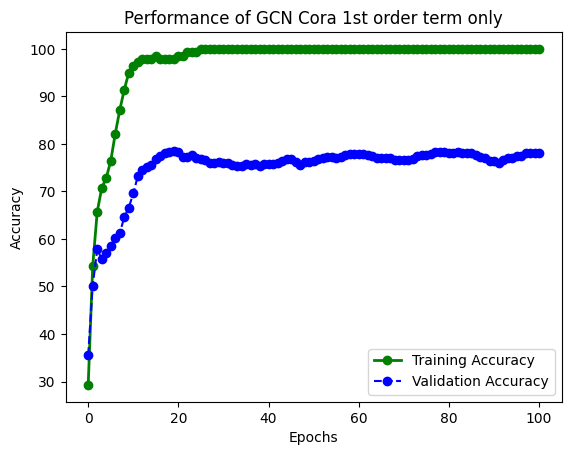

In [ ]:
model = GCNModel(in_feat=train_x.shape[-1], num_hidden=16, nclass=7, actn=F.relu, dropout=0.5).to(device)

train_y = train_y.to(device)
valid_y = valid_y.to(device)
test_y = test_y.to(device)

train_mask = cora_data.train_mask.to(device)
valid_mask = cora_data.valid_mask.to(device)
test_mask = cora_data.test_mask.to(device)

train_stats_gnn_cora = train_eval_loop_gnn_cora(model, A_norm, X, train_y, train_mask,
                                          X, valid_y, valid_mask,
                                          X, test_y, test_mask
                                       )
plot_stats(train_stats_gnn_cora, model_name="GCN Cora 1st order term only")

## 1st order model
This model is defined as follows:

$XΘ_0 + (D^{\frac{-1}{2}}AD^{\frac{-1}{2}})XΘ_1$

In [ ]:
class GCNLayer1stOrderModel(nn.Module):
    def __init__(self, in_feat, out_feat):
        super().__init__()
        self.in_feat = in_feat
        self.out_feat = out_feat

        self.projection1 = nn.Linear(in_feat, out_feat)
        self.projection2 = nn.Linear(in_feat, out_feat)

    def forward(self, x, A_norm):
        first_term = self.projection1(x) # X @ W0
        x = torch.mm(A_norm, x) # message passing
        x = first_term + self.projection2(x) # projection
        return x

    def __repr__(self):
        return f"GCNLayer ({self.in_feat} -> {self.out_feat})"

class GCNModel1stOrderModel(nn.Module):
    def __init__(self, in_feat, num_hidden, nclass, actn, dropout=None):
        super().__init__()
        self.gcn_l1 = GCNLayer1stOrderModel(in_feat, num_hidden)
        self.gcn_l2 = GCNLayer1stOrderModel(num_hidden, nclass)

        self.dropout = dropout
        self.actn = actn

    def forward(self, x, A_norm):
        x = self.actn(self.gcn_l1(x, A_norm))
        if self.dropout is not None:
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.gcn_l2(x, A_norm)
        return x

In [ ]:
A = cora_data.get_adjacency_matrix().to(device)
X = cora_data.get_fullx().to(device)

D = torch.sum(A, dim=1)
A_norm = torch.diag(D ** (-1/2)) @ A @ torch.diag(D ** (-1/2))

Epoch 0 with train loss: 1.977 train accuracy: 31.429 validation accuracy: 35.000
Epoch 10 with train loss: 0.409 train accuracy: 100.000 validation accuracy: 76.400
Epoch 20 with train loss: 0.075 train accuracy: 100.000 validation accuracy: 74.000
Epoch 30 with train loss: 0.022 train accuracy: 100.000 validation accuracy: 76.000
Epoch 40 with train loss: 0.014 train accuracy: 100.000 validation accuracy: 76.200
Epoch 50 with train loss: 0.020 train accuracy: 100.000 validation accuracy: 76.600
Epoch 60 with train loss: 0.024 train accuracy: 100.000 validation accuracy: 77.000
Epoch 70 with train loss: 0.016 train accuracy: 100.000 validation accuracy: 76.800
Epoch 80 with train loss: 0.036 train accuracy: 100.000 validation accuracy: 77.400
Epoch 90 with train loss: 0.027 train accuracy: 100.000 validation accuracy: 76.800
Epoch 100 with train loss: 0.026 train accuracy: 100.000 validation accuracy: 77.400
Our final test accuracy for the GCN is: 79.500


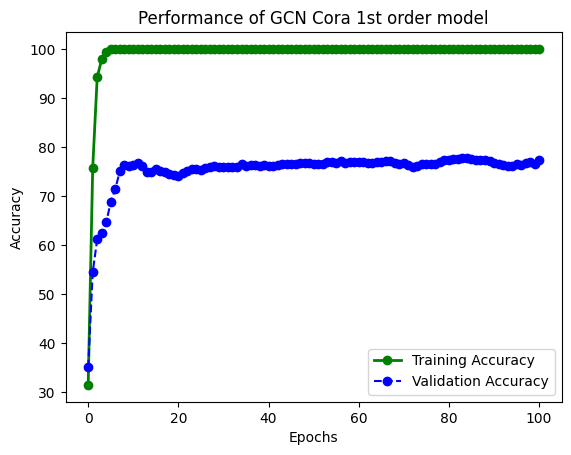

In [ ]:
model = GCNModel1stOrderModel(in_feat=train_x.shape[-1], num_hidden=16, nclass=7, actn=F.relu, dropout=0.5).to(device)

train_y = train_y.to(device)
valid_y = valid_y.to(device)
test_y = test_y.to(device)

train_mask = cora_data.train_mask.to(device)
valid_mask = cora_data.valid_mask.to(device)
test_mask = cora_data.test_mask.to(device)

train_stats_gnn_cora = train_eval_loop_gnn_cora(model, A_norm, X, train_y, train_mask,
                                          X, valid_y, valid_mask,
                                          X, test_y, test_mask
                                       )
plot_stats(train_stats_gnn_cora, model_name="GCN Cora 1st order model")

## Chebyshev Polynomials
This model is defined as follows:

$\sum_{k=0}^KT_k(\tilde{L})X\theta_k$

We set K = 2

In [36]:
A = cora_data.get_adjacency_matrix().to(device)
X = cora_data.get_fullx().to(device)

D = torch.sum(A, dim=1)
A_norm = torch.diag(D ** (-1/2)) @ A @ torch.diag(D ** (-1/2))

In [37]:
# define one layer of Chebyshev polynomial
class ChebyshevPolyLayer(nn.Module):
    def __init__(self, in_feat, out_feat, A_norm, k):
        super().__init__()
        self.in_feat = in_feat
        self.out_feat = out_feat
        self.k = k
        self.out_shape = (A_norm.shape[0], out_feat)

        # Trainable weights
        self.linear_layers = []
        for i in range(k+1):
            self.linear_layers.append(nn.Linear(in_feat, out_feat))
        self.linear_layers = nn.ModuleList(self.linear_layers)

        # Get the normalized Laplcian matrix
        I = torch.eye(A_norm.shape[0]).to(device) # I_N
        laplacian = I - A_norm # I_N - A_tilde

        # get the eigen value of Laplacian
        largest_eigval = torch.linalg.eigvalsh(laplacian).max()

        # scale the Laplacian -> (2/eig_val) * Laplacian - I_N
        scaled_laplacian = (2. / largest_eigval) * laplacian - I

        # create list for the Chebyshev polynomials
        self.t_k = []

        # first term is Identity matrix
        self.t_k.append(I)

        # second term is scaled Laplacian
        self.t_k.append(scaled_laplacian)

        # define the Chebyshev recurrence ->
        # T_k[x] = 2xT_(k-1)[x] - T_(k−2)(x), with T_0(x) = 1 and T_1(x) = x.
        def chebyshev_recurrence(t_k_minus_one, t_k_minus_two, scaled_lap):
            return (2. * (scaled_lap @ t_k_minus_one)) - t_k_minus_two

        # fill the Chebyshev polynomial list for k terms
        for i in range(2, k+1):
            self.t_k.append(chebyshev_recurrence(self.t_k[-1],
                                                 self.t_k[-2],
                                                 scaled_laplacian))

    def forward(self, x):
        out = torch.zeros(self.out_shape).to(device)
        for i in range(self.k + 1):
            x1 = self.t_k[i] @ x
            x2 = self.linear_layers[i](x1)
            out += x2
        return out

    def __repr__(self):
        return f"Chebyshev Layer ({self.in_feat} -> {self.out_feat})"

# create the Chebyshev polynomial model
class ChebyshevPolyModel(nn.Module):
    def __init__(self, in_feat, num_hidden, nclass, A_norm, k, actn, dropout=None):
        super().__init__()
        self.cheb_l1 = ChebyshevPolyLayer(in_feat, num_hidden, A_norm, k)
        self.cheb_l2 = ChebyshevPolyLayer(num_hidden, nclass, A_norm, k)

        self.dropout = dropout
        self.actn = actn

    def forward(self, x, A_norm):
        x = self.actn(self.cheb_l1(x))
        if self.dropout is not None:
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.cheb_l2(x)
        return x

Epoch 0 with train loss: 2.000 train accuracy: 36.429 validation accuracy: 18.400
Epoch 10 with train loss: 0.202 train accuracy: 100.000 validation accuracy: 74.000
Epoch 20 with train loss: 0.039 train accuracy: 100.000 validation accuracy: 74.400
Epoch 30 with train loss: 0.017 train accuracy: 100.000 validation accuracy: 75.400
Epoch 40 with train loss: 0.005 train accuracy: 100.000 validation accuracy: 76.000
Epoch 50 with train loss: 0.009 train accuracy: 100.000 validation accuracy: 74.400
Epoch 60 with train loss: 0.009 train accuracy: 100.000 validation accuracy: 76.600
Epoch 70 with train loss: 0.030 train accuracy: 100.000 validation accuracy: 78.000
Epoch 80 with train loss: 0.019 train accuracy: 100.000 validation accuracy: 77.200
Epoch 90 with train loss: 0.015 train accuracy: 100.000 validation accuracy: 75.800
Epoch 100 with train loss: 0.005 train accuracy: 100.000 validation accuracy: 77.200
Our final test accuracy for the GCN is: 80.600


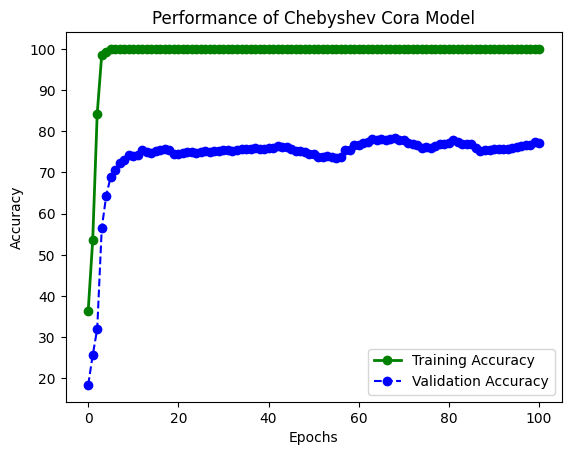

In [39]:
model = ChebyshevPolyModel(in_feat=train_x.shape[-1],
                           num_hidden=16, nclass=7,
                           A_norm=A_norm, k=2,
                           actn=F.relu, dropout=0.5).to(device)

train_y = train_y.to(device)
valid_y = valid_y.to(device)
test_y = test_y.to(device)

train_mask = cora_data.train_mask.to(device)
valid_mask = cora_data.valid_mask.to(device)
test_mask = cora_data.test_mask.to(device)

train_stats_gnn_cora = train_eval_loop_gnn_cora(model, A_norm, X, train_y, train_mask,
                                          X, valid_y, valid_mask,
                                          X, test_y, test_mask
                                       )
plot_stats(train_stats_gnn_cora, model_name="Chebyshev Cora Model")

## Final thoughts
That's it for this post. I have tried explaining GCN in the most simplest way. There are some topics I haven't covered in this post:
- The mathematical concepts behind graph convolution, as I felt, would make the post too lengthy, and readers might lose interest. Also, the reader needs to understand spectral graph theory to comprehend the derivation of the GCN equation. I have added some links in the References that try to explain the math behind the paper.

- Sparse implementation: As the adjacency matrix contains mostly zero values, doing sparse implementation is beneficial and the author has used this approach in the official released code. As this post was to explain GCN and not the "efficient implementation of GCN", I have skipped the sparse implementation. Keen readers are encouraged to explore the official code for an in-depth examination of the sparse implementation (Link provided in references).

- Training GCN on Zachary Karate Club dataset using self-supervised mechanism. I feel that the training output is too trivial to understand.

- Discussion on time complexity of GCN model and it's variants. I'll try to cover it in the next revision whenever it get time for it.

- Limitations of the GCN model: Ferenc Huszár has done a great job in his post explaining the limitations of GCN model. Furthermore, the author has acknowledged and discussed these limitations in the comments section of his blog post. I recommend all the interested readers to go through his post. I have provided the link in the references.


I would like to recommend reading the GCN paper in detail to understand the most of it. I would also recommend going through the code released by the author to understand the experiments in detail. I have added the link to it in the references. Lastly, I invite readers to find any kind of errors in this post and reach out to me on my [Email ID](mailto:nitinnilesh49@gmail.com).

## References
1. Blog by Thomas Kipf (Author of the paper) - https://tkipf.github.io/graph-convolutional-networks/
2. A great post by Matthew Bernstein on GCN - https://mbernste.github.io/posts/gcn/
3. A critical post by Ferenc Huszár - https://www.inference.vc/how-powerful-are-graph-convolutions-review-of-kipf-welling-2016-2/
4. Understanding GNNs (Distill pub post 🙏) - https://distill.pub/2021/gnn-intro/, https://distill.pub/2021/understanding-gnns/
5. Code by the author - https://github.com/tkipf/gcn
6. Geometric Deep Learning Course - https://geometricdeeplearning.com/lectures/
7. A Medium post explaining the math behind Spectral Graph Convolutions - https://medium.com/@jlcastrog99/spectral-graph-convolutions-c7241af4d8e2
8. https://www.topbots.com/graph-convolutional-networks/
9. Lectures on Spectral Graph Theory by Fan R. K. Chung - https://mathweb.ucsd.edu/~fan/research/cbms.pdf
